In [ ]:
using Pkg
Pkg.activate("/usr/local/bin/SLIM-tutorials/02-normalizing-flows")
Pkg.instantiate()

# Non-conditional Normalizing Flow Training and Sampling

This notebook is the first in a series introducing [InvertibleNetworks.jl](https://github.com/slimgroup/InvertibleNetworks.jl), a Julia package for invertible neural networks. In this tutorial, we will cover the fundamental concepts behind [Normalizing Flows (NFs)](https://arxiv.org/abs/1505.05770) and demonstrate how to use the implementations available in InvertibleNetworks.jl to train and sample from a simple non-conditional normalizing flow.

In this tutorial, we will train a Normalizing Flow using the [GLOW architecture](https://proceedings.neurips.cc/paper/2018/file/d139db6a236200b21cc7f752979132d0-Paper.pdf), which is an advanced flow-based model featuring several key components to improve training efficiency. Below, we outline the primary features of the GLOW architecture that our package has implemented:

* **Affine Coupling Layer**: The core building block of GLOW is the invertible affine coupling layer, which was originally introduced in [Real-NVP](https://arxiv.org/abs/1605.08803). 

* **Multiscale Invertible Downsampling**: The GLOW architecture supports multiscale invertible downsampling, which helps to efficiently handle high-dimensional inputs such as images. By applying downsampling, we can represent data at different scales, improving both the model's efficiency and its ability to capture important spatial correlations.

* **ActNorm**: For training stability, GLOW uses activation normalization (ActNorm). This technique replaces traditional batch normalization, providing consistent results during both training and sampling by normalizing each layer's activations to have zero mean and unit variance.

* **1x1 Convolutions**: To further enhance the model's ability to learn intricate relationships within the data, GLOW uses invertible 1x1 convolutions for channel mixing between the affine coupling layers. These convolutions help to mix information across channels and improve the model's overall expressiveness.

### Step-by-Step Overview

In this notebook, we will go through the following steps to implement a non-conditional normalizing flow using InvertibleNetworks.jl:

1. **Setup and Data Loading**: We will begin by importing the necessary libraries and loading the data that we wish to model. For this example, we'll use a simple 2 dimensional rosenbrock distribution.

2. **Define the Normalizing Flow**: Next, we'll define the structure of our normalizing flow using the GLOW components. We'll specify the number of affine coupling layers, downsampling stages, and any other hyperparameters that define the architecture.

3. **Training the Normalizing Flow**: We will train the normalizing flow by optimizing the negative log-likelihood of the data. During training, the model learns to normalize/whiten samples from the complex distribution.

4. **Sampling from the Normalizing Flow**: After training, we will demonstrate how to generate new samples from the learned distribution. This involves sampling from the base distribution and applying the learned invertible transformations.

5. **Visualizing Results**: Finally, we'll visualize the results of our training and sampling process, showingthat the samples generated by the model are close to the target distribution.

By the end of this tutorial, you should have a solid understanding of how to implement and train a basic non-conditional normalizing flow using the GLOW architecture. In the next tutorial we will extend these ideas towards conditional distributions. 


In [112]:
using InvertibleNetworks
using LinearAlgebra
using PyPlot
using Flux
using Random

Random.seed!(1234)

PyPlot.rc("font", family="serif"); 

## What is normalizing flow

Normalizing flow (NF) is a type of generative neural network containing a series of invertible layers, which aims to learn to sample from a probability distribution (e.g. cat images). During training training, a NF learns to transform examples from the target distribution (cat images) to look like white noise. Thanks to its invertibility, we can easily draw sample images from the "cat" distribution by drawing random white noise and apply the inverse of the NF.

## Target distribution

For this example, we will learn to sample from the [2-D Rosenbrock distribution](https://en.wikipedia.org/wiki/Rosenbrock_function). Accessible in InvertibleNetworks.jl
using its colloquial name: the "banana" distribution. The idea of invertible networks is that we want to learn an invertible nonlinear mapping $G$ such that

$$G_{\theta}(x) = z,$$

where $\theta$ is the network parameter, $x$ samples from the target distribution, $z$ samples from Gaussian distribution (white noise). After training, NF can sample from the target distribution via evaluating the inverse of NF on white noise, i.e., $G^{-1}_{\theta}(z)$. Let's first generate a training set and plot the target banana distribution.

In [113]:
n_train = 60000;
X_train = sample_banana(n_train);
size(X_train) #(nx, ny, n_channels, n_samples) Note: we put 2 dimensions as channels

(1, 1, 2, 60000)

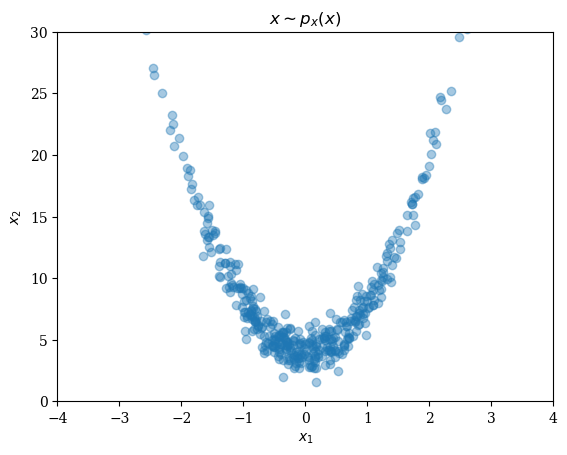

In [114]:
fig = figure(); title(L"x \sim p_x(x)")
scatter(X_train[1,1,1,1:400], X_train[1,1,2,1:400]; alpha=0.4);
xlabel(L"x_1"); ylabel(L"x_2");
xlim(-4,4); ylim(0,30);


## Change of Variables Formula

The change of variables formula is a fundamental concept in Normalizing Flows. It allows us to evaluate the probability density of a transformed random variable under a monotone function $f : \mathbf{X} \rightarrow \mathbf{Z}$. The formula is given as:

$$
p_x(x) = p_z(f(x)) \, |\det \frac{\partial f}{\partial x}|
$$

Here, $p_x(x)$ represents the probability density of $x$ in the target distribution, and $p_z(f(x))$ is the density of the transformed variable in the latent space. The term $|\det \frac{\partial f}{\partial x}|$, the absolute determinant of the Jacobian of $f$, accounts for the change in volume during the transformation. This determinant ensures that we properly adjust the density as we map from one space to another, preserving the total probability.

In the context of Normalizing Flows, this formula provides the mechanism to compute exact densities, which is crucial for training. It enables a likelihood-based approach, giving us a maximum likelihood framework for optimizing our parameterized Normalizing Flow model $G_{\theta}$. 

---

## Training a Normalizing Flow

Training a Normalizing Flow involves optimizing the parameters $\theta$ of the model $G_{\theta}$ to maximize the likelihood of the data. This is framed as a maximum likelihood estimation (MLE) problem. The log-likelihood objective for samples drawn from the data distribution $X$ is given by:

$$
\underset{\mathbf{\theta}}{\operatorname{argmax}} \, \mathbb{E}_{x \sim p(x)} [\log p(x)].
$$

Since we do not have direct access to the entire data distribution, we approximate the expectation using a finite set of samples from the training dataset $X_{\text{train}}$. This converts the optimization into a practical empirical maximization:

$$
\underset{\mathbf{\theta}}{\operatorname{max}} \, \frac{1}{N} \sum_{x \in X_{\text{train}}} \log p(x),
$$

where $N$ is the number of training samples. To simplify optimization, we typically reformulate this as a minimization problem by minimizing the negative log-likelihood:

$$
\underset{\mathbf{\theta}}{\operatorname{min}} \, \frac{1}{N} \sum_{x \in X_{\text{train}}} -\log p(x).
$$

Applying the change of variables formula, we can express the negative log-likelihood as:

$$
\underset{\mathbf{\theta}}{\operatorname{min}} \, \frac{1}{N} \sum_{x \in X_{\text{train}}} \left[ \frac{1}{2} \|G_\theta(x)\|_2^2 - \log |\det \nabla_x G_\theta(x)| \right].
$$

This equation reveals the two main components of the loss function:

1. The term $\frac{1}{2} \|G_\theta(x)\|_2^2$ ensures that the transformed latent representation $\hat{z} = G_\theta(x)$ is likely under the base distribution here  a standard Gaussian distribution.
2. The term $-\log |\det \nabla_x G_\theta(x)|$ adjusts for the change in density due to the transformation and ensures that the model learns a valid probability distribution.

The objective is to train $G_\theta$ so that applying it to data samples $x$ results in latent variables $\hat{z}$ that resemble normal noise. 

---

## Backpropagation and Parameter Updates

One of the key advantages of Normalizing Flows is their invertibility. This property significantly improves memory effiency during backpropagation. Since the network is invertible, intermediate states do not need to be stored during forward propagation. Instead, the network can reconstruct these states during backpropagation, reducing memory usage.

When training the model, we calculate gradients of the loss with respect to the trainable parameters $\theta$ using backpropagation. Calling the `G.backward` function initiates this process. Given the final output $Z$, the network recalculates intermediate states and computes gradients at each layer. This is achieved by backpropagating the residuals $dZ$.

This efficient backpropagation process leverages the invertibility of the network, allowing for scalable training even with deep Normalizing Flow architectures [Paper comparing PyTorch normalizing flows vs InvertibleNetworks.jl](https://joss.theoj.org/papers/10.21105/joss.06554).


In [115]:
function loss(G, X)
    batch_size = size(X)[end]
    
    # Perform the forward pass:
    # Z: Latent representation of X under the flow
    # lgdet: Log-determinant of the Jacobian matrix of the flow
    Z, lgdet = G.forward(X)
    
    # Compute the L2 loss term:
    # This is equivalent to the negative log-likelihood under a standard normal distribution.
    l2_loss = 0.5 * norm(Z)^2 / batch_size  
    
    # Compute the gradient of the L2 loss with respect to Z:
    # This will be used for backpropagation.
    dZ = Z / batch_size  
    
    # Perform the backward pass:
    # This sets the gradients of G's parameters using the provided dZ and Z.
    # The log-determinant term is internally included in G's backward computation.
    G.backward(dZ, Z)
    
    return (l2_loss, lgdet)
end

loss (generic function with 1 method)

In [116]:
nx          = 1
ny          = 1

#network architecture
n_in        = 2 #put 2d variables into 2 channels
n_hidden    = 32
levels_L    = 1
flowsteps_K = 10

G = NetworkGlow(n_in, n_hidden, levels_L, flowsteps_K;)
#G = G |> gpu 

#training parameters
batch_size = 150
num_batches = cld(n_train, batch_size)
num_epoch = 3

lr = 2f-4
opt = Adam(lr)

loss_l2_list    = []
loss_lgdet_list = []

@time for e in 1:num_epoch
    for j = 1:num_batches
        Base.flush(Base.stdout)
        idx = ((j-1)*batch_size+1):(j*batch_size)
        
        X = X_train[:,:,:,idx]
        #X = X |> gpu
        
        losses = loss(G, X) #sets gradients of G
        
        append!(loss_l2_list,losses[1])
        append!(loss_lgdet_list,losses[2])
        
        (j%50==0) && println("Epoch=",e, "/", num_epoch, " Batch Iteration=", j, "/", maxiter,
                "; f l2 = ",   loss_l2_list[end], 
                "; f lgdet = ",loss_lgdet_list[end], 
                "; f full objective = ",loss_l2_list[end] - loss_lgdet_list[end])
         
        for p in get_params(G) 
            update!(opt,p.data,p.grad)
        end
    end
end

Epoch=1/3 Batch Iteration=50/400; f l2 = 0.6152753194173177; f lgdet = -2.2778387; f full objective = 2.893114026387533
Epoch=1/3 Batch Iteration=100/400; f l2 = 0.6404534912109375; f lgdet = -1.9737344; f full objective = 2.614187870025635
Epoch=1/3 Batch Iteration=150/400; f l2 = 0.6127808125813802; f lgdet = -1.6712306; f full objective = 2.2840113671620688
Epoch=1/3 Batch Iteration=200/400; f l2 = 0.8530481974283854; f lgdet = -1.3278866; f full objective = 2.180934778849284
Epoch=1/3 Batch Iteration=250/400; f l2 = 0.6615299479166666; f lgdet = -1.0172187; f full objective = 1.6787486569086711
Epoch=1/3 Batch Iteration=300/400; f l2 = 1.0765779622395832; f lgdet = -0.6507001; f full objective = 1.727278054555257
Epoch=1/3 Batch Iteration=350/400; f l2 = 0.7824332682291667; f lgdet = -0.31275547; f full objective = 1.095188733736674
Epoch=1/3 Batch Iteration=400/400; f l2 = 1.0211442057291666; f lgdet = -0.32829782; f full objective = 1.3494420293966929
Epoch=2/3 Batch Iteration=50

## Check training objective log 
There are various ways to train a NF:
- train your network to convergence of objective
- use earlystopping to prevent overfitting 
- check normality of $\hat z = G_{\theta}(x)$ with [qq plots](https://en.wikipedia.org/wiki/Q%E2%80%93Q_plot) 
- as a heuristic simply observe $\hat z = G_{\theta}(x)$ until it looks normal under the eyeball norm. 

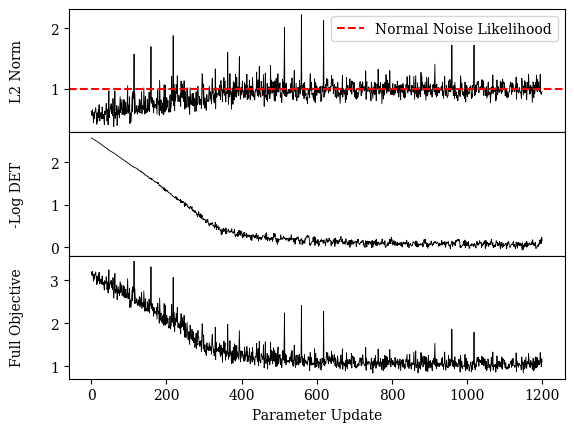

PyObject Text(0.5, 24.0, 'Parameter Update')

In [122]:
gt_l2 = 0.5*nx*ny*n_in #likelihood of gaussian noise

fig, axs = subplots(3, 1, sharex=true)
fig.subplots_adjust(hspace=0)

axs[1].plot(loss_l2_list, color="black", linewidth=0.6); 
axs[1].axhline(y=gt_l2,color="red",linestyle="--",label="Normal Noise Likelihood")
axs[1].set_ylabel("L2 Norm")
axs[1].yaxis.set_label_coords(-0.09, 0.5)
axs[1].legend()

axs[2].plot(-loss_lgdet_list, color="black", linewidth=0.6); 
axs[2].set_ylabel("-Log DET") 
axs[2].yaxis.set_label_coords(-0.09, 0.5) 

axs[3].plot(loss_l2_list - loss_lgdet_list, color="black", linewidth=0.6); 
axs[3].set_ylabel("Full Objective") 
axs[3].yaxis.set_label_coords(-0.09, 0.5)
axs[3].set_xlabel("Parameter Update") 

## Testing a Normalizing Flow 
Since we have access to $p_x(x)$ in the simple 2D Rosenbrock distribution, we can verify that generative samples from our trained network  $\hat x = G^{-1}_\theta(z)$  look like they come from $p_x(x)$.

We can verify this visually (easy since this is a 2D dataset) and under the ground truth density of $p_x(x)$.

## Testing a Normalizing Flow

Once we have trained a Normalizing Flow model, it is important to verify its performance by evaluating whether the generative samples align with the target data distribution. In this case, since we have access to the ground truth density $p_x(x)$ from the simple 2D Rosenbrock distribution, we can directly compare the output of our model against this known distribution. Specifically, we aim to check whether the generative samples $\hat{x} = G^{-1}_\theta(z)$, where $z$ is sampled from the latent space (typically a standard Gaussian), resemble samples drawn from $p_x(x)$.

There are multiple ways to perform this verification. First, we can conduct a **visual inspection**. Because the Rosenbrock distribution is two-dimensional, it is straightforward to plot both the generative samples $\hat{x}$ and a set of samples drawn directly from $p_x(x)$. By overlaying these plots or visualizing their density contours, we can qualitatively assess whether the learned distribution captures the correct shape and characteristics of the target distribution. 

Second, we can perform a **quantitative evaluation** by computing the likelihood of the generative samples under the true density $p_x(x)$. For each generative sample $\hat{x}$, we evaluate $p_x(\hat{x})$ and compare the resulting distribution of likelihood values to those obtained from true samples of $p_x(x)$. A close match between the two distributions would indicate that the Normalizing Flow has successfully learned the target distribution.


Let's start by taking samples from $z \sim N(0,I) $

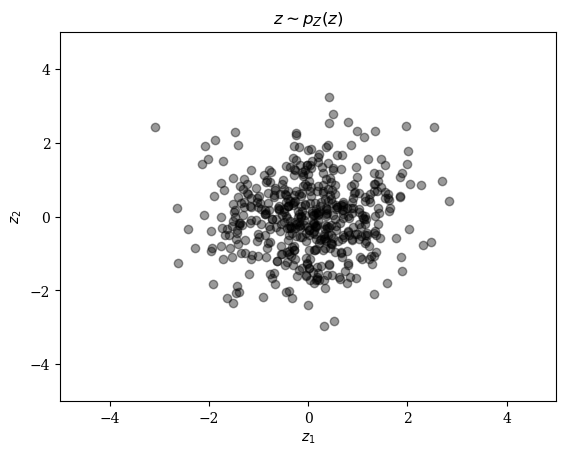

In [123]:
num_test_samples = 500;
Z_test = randn(Float32, nx, ny, n_in, num_test_samples);

fig = figure(); title(L"z \sim p_{Z}(z)")
scatter(Z_test[1,1,1,:], Z_test[1,1,2,:]; alpha=0.4, color="black");
xlabel(L"z_1"); ylabel(L"z_2");
xlim(-5,5); ylim(-5,5);


## Make generative samples from our target distribution by passing Gaussian noise through the inverse network. 

Pass Normal samples $z \sim N(0,I)$ through the inverse network $\hat x = G^{-1}_\theta(z)$ 

In [124]:
X_test = G.inverse(Z_test);

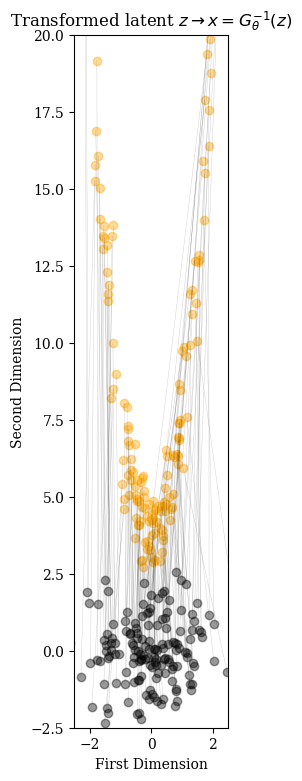

In [125]:
trans_num = 150
start_points = [(Z_test[1,1,1,i], Z_test[1,1,2,i]) for i in 1:trans_num]
end_points = [(X_test[1,1,1,i], X_test[1,1,2,i]) for i in 1:trans_num]

fig, ax = plt.subplots(figsize=(7, 9)); title(L"Transformed latent $z \rightarrow x=G^{-1}_\theta(z)$");

for line in zip(start_points, end_points)
    plot([line[1][1],line[2][1]], [line[1][2] ,line[2][2]], alpha=0.2, linewidth=0.3, color="black")
    scatter(line[1][1], line[1][2], marker="o",alpha=0.4, color="black")
    scatter(line[2][1], line[2][2], marker="o",alpha=0.4, color="orange")
end
xlabel("First Dimension"); ylabel("Second Dimension");
ylim(-2.5,20); xlim(-2.5,2.5); ax.set_aspect(1)

Visually compare generative samples with samples from the ground truth density $x \sim p_x(x) $

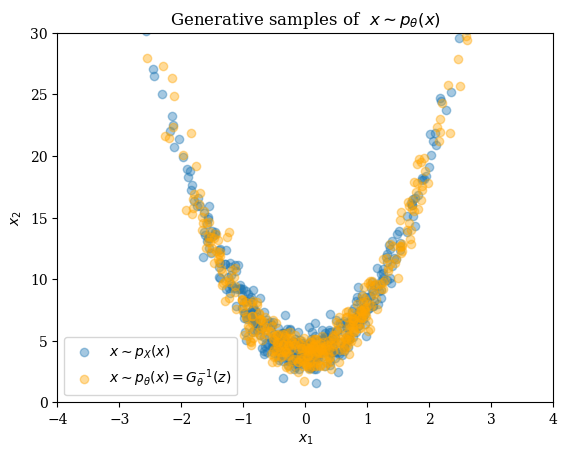

In [126]:
fig = figure(); title(L"Generative samples of  $x \sim p_{\theta}(x)$")
scatter(X_train[1,1,1,1:400], X_train[1,1,2,1:400]; alpha=0.4, label = L"x \sim p_{X}(x)");
scatter(X_test[1,1,1,1:400], X_test[1,1,2,1:400]; alpha=0.4, color="orange", label = L"x \sim p_{\theta}(x) = G_\theta^{-1}(z)");
xlabel(L"x_1"); ylabel(L"x_2");
xlim(-4,4); ylim(0,30);
legend();